In [58]:
# Load dataset before analysing the assesment file setup
from prettytable import PrettyTable
import pandas as pd 
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

import torch

import self_made_functions as smf
# df_fin, wv_path = smf.get_df()
df_assessment, wv_path = smf.get_correct_df()

mt = pd.DataFrame(columns=['File name', 'Word', 'idx', 'Model'])

In [59]:
# path = './Transcriptions/empty_transcription_v1.csv'
path = 'Transcriptions/true_empty_transcriptions_v1.csv'
empty_transcription_1 = pd.read_csv(path)
empty_transcription_1.head(2)

,file_name,CER,target_word,global_score,PER,transcribed_word,model_name
0,a06_kropp.wav,1.0,kropp,3,0.500000,NaN,nb-whisper-base
1,a11_turn.wav,1.0,turn,2,0.666667,NaN,nb-whisper-base


In [60]:
# Information about the empty transcription
# Which models that has empty transcription and how many they have
model_group = empty_transcription_1.groupby('model_name')
print(f'Empty transcriptions for {path.split("/")[-1].split(".c")[0]}')
print(model_group.size())

Empty transcriptions for true_empty_transcriptions_v1
model_name
nb-whisper-base               35
nb-whisper-base-verbatim      97
nb-whisper-medium              7
nb-whisper-medium-verbatim     1
dtype: int64


In [61]:
empty_transcription_1['global_score'].value_counts()

global_score
3    38
5    35
4    31
1    19
2    17
Name: count, dtype: int64

In [62]:
# Add speaker id column
empty_transcription_1['speaker_id'] = empty_transcription_1['file_name'].str.slice(start=0, stop=3)
empty_transcription_1 = empty_transcription_1.sort_values(by='speaker_id', ascending=False)

# Check the unique speakers
who = empty_transcription_1['speaker_id'].unique()
print("total unique speaker id's : \n", who, '\n')

total unique speaker id's : 
 ['d19' 'd18' 'd17' 'd15' 'd14' 'd13' 'd11' 'd09' 'd08' 'd07' 'd05' 'd01'
 'a34' 'a33' 'a30' 'a25' 'a21' 'a20' 'a18' 'a15' 'a14' 'a13' 'a12' 'a11'
 'a07' 'a06' 'a03'] 



In [63]:
# Unique speakers in each model group
print("total files per each unique speaker id : \n")
model_group['speaker_id'].nunique()

total files per each unique speaker id : 



model_name
nb-whisper-base                9
nb-whisper-base-verbatim      26
nb-whisper-medium              4
nb-whisper-medium-verbatim     1
Name: speaker_id, dtype: int64

Conclusions from this results are that the base models has a harder time transcribing, and has more empty transcriptions than the medium models. It also concludes with nb-whisper-medium-verbatim beeing the best of not giving emty transcriptions, (If you dissregard teh tiny models that has zero empty transcriptions).
The normal base model and not the nastional libaris model are better at not returnting empty transcriptions than most of the national libary models amongst the models giving emty transcriptions.

Based on the results, it can be concluded that the base models have a harder time not returnting empty transcribing compared to the medium models. The tiny models does not return any empty transcriptions, (but the total metric sores fro the other models are better). A theory why tiny don't return emty transcriptions the same whay can be it has less fetures to work with. It was also observed that the "OpenAI/medium" also does not have any empty transciptions, and amongs the empty transcriptions "nb-whisper-medium-verbatim" model comes out on top with only one empty transcription. This models comes into second place looking at the mean metric score. The perfomance mean from nb-whisper-medium is the best for all the scores. 

NB! Recall is better for tiny in the lower rannced scores, but recall is better for the medium for the higher scores. 

FIND OUT:
Hva er score vekten blant de forskjellige modellene? Gir tiny og mindre modellene konsekvent lavere score? 


In [64]:
identify_tabel_total = PrettyTable()
identify_tabel_total.field_names = ['Speaker id', 'Number of files', 'In Model']

for speaker in who:
    number_of_files = empty_transcription_1[empty_transcription_1['speaker_id'] == speaker].shape[0]
    in_model = empty_transcription_1['model_name'][empty_transcription_1['speaker_id'] == speaker].unique()
    identify_tabel_total.add_row([speaker, number_of_files, in_model])

print(identify_tabel_total)

+------------+-----------------+----------------------------------------------------------------------------+
| Speaker id | Number of files |                                  In Model                                  |
+------------+-----------------+----------------------------------------------------------------------------+
|    d19     |        19       |               ['nb-whisper-base-verbatim' 'nb-whisper-base']               |
|    d18     |        4        |               ['nb-whisper-base-verbatim' 'nb-whisper-base']               |
|    d17     |        2        |                        ['nb-whisper-base-verbatim']                        |
|    d15     |        1        |                        ['nb-whisper-base-verbatim']                        |
|    d14     |        4        |                        ['nb-whisper-base-verbatim']                        |
|    d13     |        7        | ['nb-whisper-base-verbatim' 'nb-whisper-medium-verbatim' 'nb-whisper-base' |
|         

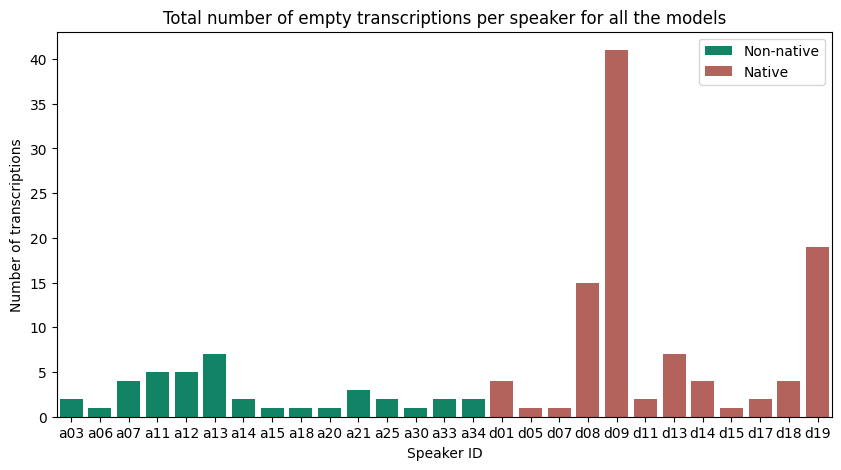

In [65]:
# Check the number of files per speaker and put in a table
x = PrettyTable()
x.field_names = ['Speaker id', 'Number of files']

for speaker in who:
    number_of_files = empty_transcription_1[empty_transcription_1['speaker_id'] == speaker].shape[0]
    x.add_row([speaker, number_of_files])

# plot the number of files per speaker
empty_transcription_1 = empty_transcription_1.sort_values(by='speaker_id', ascending=True)
native = empty_transcription_1[empty_transcription_1['speaker_id'].str.contains('d')]
non_native = empty_transcription_1[empty_transcription_1['speaker_id'].str.contains('a')]

plt.figure(figsize=(10, 5))
sns.countplot(x='speaker_id', data=non_native, color='#00966E', label = 'Non-native')
sns.countplot(x='speaker_id', data=native, color='#C1554D', label = 'Native')

plt.title('Total number of empty transcriptions per speaker for all the models')
plt.xlabel('Speaker ID')
plt.ylabel('Number of transcriptions')
plt.savefig('./OWT_empty_transcriptions_per_speaker.png', bbox_inches='tight')
# plt.show()

In [68]:
# Of all the empty transcription who many of the files hva nice or repetition assigned to them?
empty_transcription_1[['Repetition', 'Noise']] = None

for i, row in empty_transcription_1.iterrows():
    assesment = df_assessment[df_assessment['File name'] == row['file_name']].copy()
    empty_transcription_1.loc[i, 'Repetition'] = assesment['Repetition'].values[0]
    empty_transcription_1.loc[i, 'Noise'] = assesment['Noise/Disruption'].values[0]
empty_transcription_1['Repetition'].value_counts()

Repetition
1.0    2
Name: count, dtype: int64

In [87]:
# print(len(empty_transcription_1['Noise']))
# print(empty_transcription_1['Noise'].value_counts())
# Noise d09
andel = empty_transcription_1['Noise'].value_counts().values[0]
total_len =len(empty_transcription_1['Noise'])
precentage = (andel/total_len)*100
print('Precentage of empty transcription with noise: ', int(precentage), '%')

# Noise d09
andel = empty_transcription_1['Noise'][empty_transcription_1.speaker_id == 'd09'].value_counts().values[0]
total_len =len(empty_transcription_1['Noise'][empty_transcription_1.speaker_id == 'd09'])
precentage = (andel/total_len)*100
print('Precentage of empty transcription with noise: ', int(precentage), '%')

# Noise d08
andel = empty_transcription_1['Noise'][empty_transcription_1.speaker_id == 'd08'].value_counts().values[0]
total_len =len(empty_transcription_1['Noise'][empty_transcription_1.speaker_id == 'd09'])
precentage = (andel/total_len)*100
print('Precentage of empty transcription with noise: ', int(precentage), '%')

# Noise d19
andel = empty_transcription_1['Noise'][empty_transcription_1.speaker_id == 'd08'].value_counts().values[0]
total_len =len(empty_transcription_1['Noise'][empty_transcription_1.speaker_id == 'd09'])
precentage = (andel/total_len)*100
print('Precentage of empty transcription with noise: ', int(precentage), '%')

Precentage of empty transcription with noise:  52 %
Precentage of empty transcription with noise:  90 %
Precentage of empty transcription with noise:  21 %
Precentage of empty transcription with noise:  21 %


In [27]:
# Look at transcription from specific child and model
df_assessment

child_d09 = empty_transcription_1[(empty_transcription_1['speaker_id']==d09) & (empty_transcription_1['model_name']=='nb-whisper-base-verbatim')]

Repetition	Noise


# Wrote this code and got SettingWithCopyWarning, so gave to GPT to fix. It added .copy() and .loc()
child_d09 = empty_transcription_1[empty_transcription_1['speaker_id'] == 'd09']
child_d09_medium_verbatim = child_d09[child_d09['Model'] == 'nb-whisper-base-verbatim'].copy( )
child_d09_medium_verbatim.drop(columns=['Model', 'speaker_id'], inplace=True)

for idx, row in child_d09_medium_verbatim.iterrows():
    score = int(df_fin.loc[df_fin['File name'] == row['File name'], 'Score'].values[0])
    repetition = df_fin.loc[df_fin['File name'] == row['File name'], 'Repetition'].values[0]
    noise = df_fin.loc[df_fin['File name'] == row['File name'], 'Noise/Disruption'].values[0]
    
    child_d09_medium_verbatim.loc[idx, 'Score'] = score
    child_d09_medium_verbatim.loc[idx, 'Noise'] = noise
    child_d09_medium_verbatim.loc[idx, 'Repetition'] = repetition
    
child_d09_medium_verbatim

,File name,Word,idx,Score,Repetition,Noise
140,d09_glorie.wav,glorie,7620,2.0,NaN,1.0
65,d09_loepe.wav,løpe,516,5.0,NaN,1.0
155,d09_krykke.wav,krykke,8753,3.0,NaN,1.0
69,d09_skjorte.wav,skjorte,1318,3.0,NaN,1.0
72,d09_oere.wav,øre,1837,4.0,NaN,1.0
73,d09_oedelagt.wav,ødelagt,1986,4.0,NaN,1.0
77,d09_bryter.wav,bryter,2228,5.0,NaN,1.0
147,d09_kvart.wav,kvart,8136,4.0,NaN,NaN
146,d09_internett.wav,internett,8060,4.0,NaN,NaN
135,d09_klo.wav,klo,7182,5.0,NaN,1.0


In [33]:
import wave

def get_bit_depth(filename):
    try:
        with wave.open(filename, 'rb') as wav_file:
            sampwidth = wav_file.getsampwidth()  # Get sample width in bytes
            bit_depth = sampwidth * 8  # Convert bytes to bits
            return bit_depth
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        return None

filename = '/talebase/data/speech_raw/teflon_no/speech16khz/d09_loepe.wav'
bit_depth = get_bit_depth(filename)
print(f"Bit Depth: {bit_depth}")


Bit Depth: 16


In [35]:
# Energy in audio signal
import numpy as np
import librosa

def calculate_energy(audio_file_path):
    # Load the audio file. y = audio time series, sr = sample rate
    y, sr = librosa.load(audio_file_path, sr=None)
    
    # Calculate the mean square energy for the signal
    # this does not give the 
    energy = np.sum(y**2) / len(y)
    
    # Convert energy to dB
    bit_depth = 16
    ref = 2**(bit_depth - 1)  # Reference level for 16-bit audio
    dB_energy = 10 * np.log10(energy / ref)

    return energy, dB_energy

print('The energy of the audio signal')
# iterate throug the files taht are empty and see if they are better
for idx, row in child_d09_medium_verbatim.iterrows():
    path = os.path.join(wv_path, row['File name'])
    energy, dB_energy = calculate_energy(path)
    print(f"{row['File name']} is: {energy}")
    
    child_d09_medium_verbatim.loc[idx, 'Energy [db]'] = dB_energy
    child_d09_medium_verbatim.loc[idx, 'Energy'] = np.round(energy, 7)


The energy of the audio signal
d09_glorie.wav is: 0.0008240832487742106
d09_loepe.wav is: 0.0001424375573794047
d09_krykke.wav is: 7.368132472038269e-05
d09_skjorte.wav is: 5.149570604165395e-05
d09_oere.wav is: 0.0002613609035809835
d09_oedelagt.wav is: 0.0005982209046681722
d09_bryter.wav is: 9.446534514427186e-05
d09_kvart.wav is: 0.00016679108142852783
d09_internett.wav is: 0.0007659134864807129
d09_klo.wav is: 0.0011495134035746256
d09_krakk.wav is: 7.645402103662491e-06
d09_brun.wav is: 0.001258568286895752
d09_fjorten.wav is: 0.0002312701940536499
d09_port.wav is: 0.00010833814740180969
d09_skjerf.wav is: 0.00010497146844863891
d09_trapp.wav is: 1.1480388542016347e-05
d09_doer.wav is: 0.00011048136154810588
d09_troll.wav is: 0.0011366293430328368
d09_trylle.wav is: 0.0002907172441482544
d09_kort.wav is: 6.837803622086843e-05
d09_blomst.wav is: 4.7556752959887186e-05
d09_flue.wav is: 0.00028415717681248983
d09_stoevel.wav is: 0.0005190191268920898


In [37]:
child_d09_medium_verbatim.to_csv('./child_d09_medium_verbatim.csv', index=False)

In [ ]:
# Spectrograms
import librosa
import librosa.display
import matplotlib.pyplot as plt

def plot_spectogram(file_name  ):
    # Load audio file
    y, sr = librosa.load(file_name)

    # Perform STFT
    S = librosa.stft(y)

    # Convert to dB scale
    S_dB = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # Plot the spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()





In [ ]:
# compait with same child but where the model gave score 5 and the assesors gave score 5
child_d09_medium_verbatim_comp = pd.DataFrame()
child_d09_medium_verbatim_comp



In [10]:
# Put different colors on a and d:
def get_color(speaker_id):
    if speaker_id == 'a':
        return 'red'
    else:
        return 'blue'

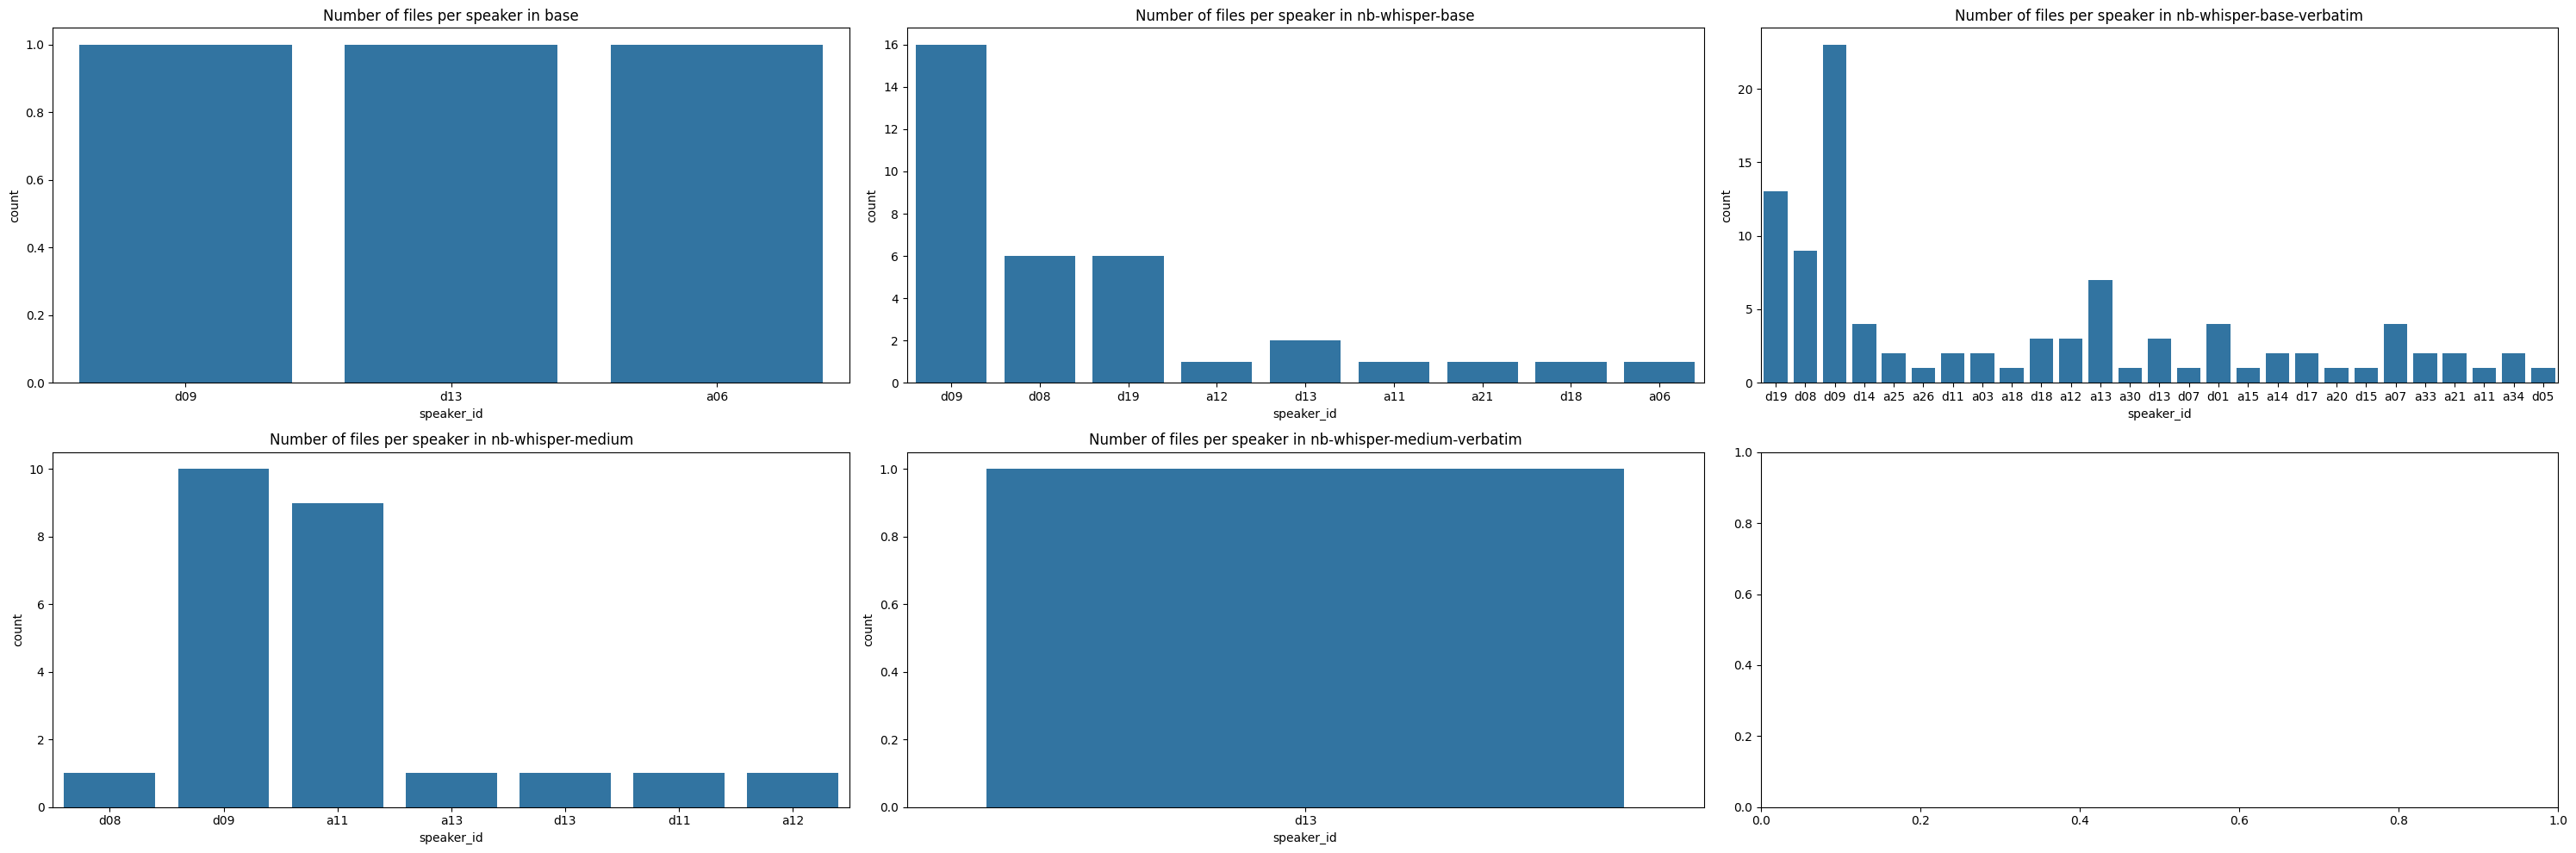

In [11]:
model_names = model_group.groups.keys()
colums = 3
number_of_plots = len(model_names) % colums
# Make a subplot for each model with 2 columns
fig, axs = plt.subplots(number_of_plots, colums, figsize=(10*colums, 5*number_of_plots))

# plot the number of files per speaker in each model
for i, model in enumerate(model_names):
    model_data = model_group.get_group(model)
    sns.countplot(x='speaker_id', data=model_data, ax=axs[i//colums, i%colums])
    axs[i//colums, i%colums].set_title(f'Number of files per speaker in {model}')

fig.tight_layout()
plt.show()


In [12]:
# Mean score of each of the candidates
# Load the scores
empty_transcription_1['idx'].values


# for id in who:
#     print(f"Speaker {id} has the following scores: \n")
    
#     print(empty_transcription_1[empty_transcription_1['speaker_id'] == id]['Score'].describe(), '\n')
    
#     # Mean score of each of the candidates
#     print(f"Mean score of speaker {id} is: \n")
#     print(empty_transcription_1[empty_transcription_1['speaker_id'] == id]['Score'].mean(), '\n')


array([3137, 3722, 4421, 7894, 3024, 2707, 7517, 2627, 5539, 3836, 6609,
       2046, 1286, 8275, 4998, 7181, 1286,  388, 6609, 5959, 4430, 2283,
       8697, 7653, 4106, 4737, 8356, 4736,  687, 4414, 3146, 3978, 3978,
       8891, 3978, 3978, 8891, 3978, 4654, 2003, 4654, 7620,  516, 8753,
       1318, 1837, 1986, 2228, 8136, 8060, 7182, 3941, 6816, 2843, 6621,
       6492, 3223, 3452, 5625, 3819, 5291, 3850, 3850, 2407, 7182, 3223,
       1065,  565, 7727, 7620, 7272, 7101, 6816, 6621, 6194, 3923, 3850,
       3526, 3223, 2407, 1240, 1065,  516, 1465, 9165, 4578, 3923, 6194,
       5504, 7182, 3941, 8382, 5719, 4687, 4591, 3883, 7205, 2277, 4287,
       7389, 3955,  396,  396,  993, 7774,  803, 8382, 3332, 7522, 8604,
       3433, 7348, 5577, 6698, 9071, 8615, 5438, 2989, 1487, 7655, 1438,
       5956, 9094, 5956, 4203, 2191, 3498, 3663, 4744, 5562, 1827, 3372,
       8365, 4211, 2860, 6739, 6092, 8249, 3747, 5862, 3747, 2716, 8946,
       3205, 2550, 8518, 6007, 1659, 6549, 7279, 49

In [13]:
import pandas as pd

df1 = df_fin
df2 = empty_transcription_1

# Extract the start of filenames in df2 that match the beginning of filenames in df1
matching_indices = []
for start_name in who:
    matching_rows = df1[df1['File name'].str.startswith(start_name)]
    if not matching_rows.empty:
        matching_indices.append(matching_rows.index.values)

# Create a new DataFrame to hold the merged results
merged_df = pd.DataFrame()

# Iterate through the indices of matching rows in df1 and merge with df2
for indices in matching_indices:
    temp_df = pd.concat([df1.loc[indices], df2])
    merged_df = pd.concat([merged_df, temp_df])

# Reset index to clean up

merged_df.reset_index(drop=True, inplace=True)

print(merged_df)


            File name  Score  Prosody  Noise/Disruption  Pre-speech noise  \
0       d19_hylle.wav    2.0      1.0               NaN               NaN   
1      d19_artist.wav    3.0      NaN               NaN               NaN   
2        d19_kart.wav    5.0      NaN               1.0               NaN   
3        d19_jern.wav    4.0      NaN               1.0               NaN   
4       d19_lytte.wav    4.0      1.0               1.0               NaN   
...               ...    ...      ...               ...               ...   
9447     a07_kurv.wav    NaN      NaN               NaN               NaN   
9448    a06_kropp.wav    NaN      NaN               NaN               NaN   
9449  a06_fregner.wav    NaN      NaN               NaN               NaN   
9450      a03_hus.wav    NaN      NaN               NaN               NaN   
9451      a03_gul.wav    NaN      NaN               NaN               NaN   

      Repetition     Word Pronunciation pronScores    Assessor     idx  \
0

In [14]:

# speaker_a = np.array_split(who, 
who = np.array_split(who, 5)
print('split unique speaker id into groups : \n', who, '\n')



split unique speaker id into groups : 
 [array(['d19', 'd18', 'd17', 'd15', 'd14', 'd13'], dtype=object), array(['d11', 'd09', 'd08', 'd07', 'd05', 'd01'], dtype=object), array(['a34', 'a33', 'a30', 'a26', 'a25', 'a21'], dtype=object), array(['a20', 'a18', 'a15', 'a14', 'a13'], dtype=object), array(['a12', 'a11', 'a07', 'a06', 'a03'], dtype=object)] 



# Empty Transcriptions

This notebook focus on analysing and handing the empty transcriptions that are generated by the models.

### Information regarding the empty transcriptions [Report food 📚🐲] 

During the transcription phase of the prosjekt the base and medoum models have atendesy top return empthy striongs. there could be several reasons for this result. First of all, giving Whisper data it is not used to see in its traing data set it can get confused. It is traind on adult speaks, and given sencenses. The dataset used have children talking differntly with a different pich than adult speakres. This experiment also gives it one and one word around 3 seconds [instead of the 30 second that is the set chunk lengdt by defult in the model]. When the model gets "confused" it can either give an empty striong or in some cases halusinate. The models is made predictiong what comes next si it is also instences of the model transcribing text where ther is in facts no words.



#### Find out if there is one person fucking up the transcriptions 

1) Lenght of the empty files for each model
1) Look at the speaker ID
2) Look at the specific energy for the wavefiles 
3) Compair the mean energy witht the transcribed files vs. the not transcribed files  


In [19]:
# Check if there is any words missing from the data frame
print('Null values in Words column ', df_fin['Word'].isnull().sum())
print('NaN  values in Words column ', df_fin['Word'].isna().sum())

# ANSWER: No, no words are missing



Null values in Words column  0
NaN  values in Words column  0


### Check and Plot the empty strings found 🐉
Look at the plot and score of each word.
Do you se any patterns? No

In [20]:
# Libaries
import whisper
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


############### Put in the posebility to 
# Global variables
sampling_rate = 16000


# Check why some strings are empty - Egen kode ingen GPT

# 
def check_specific_word_plot(datpat:str = '/talebase/data/speech_raw/teflon_no/speech16khz/', df:pd.DataFrame=df_fin, sr:int = sampling_rate, wave_number:int=0, model=asr, plot: bool=True):
    wv_path = datpat + df_fin['File name'][wave_number]
    word = df['Word'][wave_number]
    trans = model(wv_path, generate_kwargs={'task': 'transcribe', 'language': 'no'})
    
    print(f'Word nr {wave_number} :', word) # Check if the does not word exist [No]
    print('Trans :', trans) # Check if the word is not transcribed [Yes]
    print('Score :', df_fin['Score'][wave_number]) # Check if the score is bad [No]

    # Check if the audio is empty [No]
    audio = whisper.load_audio(f"{wv_path}", sr) # (Func)
    print('len(audio) :', len(audio))
    print('Type :', type(audio))

    # Check if the audio looks weird [No]
    sec = len(audio) / sr # the wavefrom duration in seconds
    print('Clip duration : ', sec)

    if plot: 
        # Calculate time axis
        time = np.linspace(0, sec, num=len(audio))

        # Plot waveform
        sns.set_theme(style="white", palette='deep')
        sns.set_style("ticks") 

        plt.figure(figsize=(10, 4))
        sns.lineplot(x=time, y=audio)

        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title('Audio Waveform')
        plt.show()

# empty_string = [516, 2046]

# for nr in empty_string:
#     # print(nr)
#     check_specific_word_plot(wave_number=nr)

# # Did you find out why the string is empty? 
# # No, but the word does not get transcribed for some reason, [Ask: Giampiero]

NameError: name 'asr' is not defined

In [ ]:
# Help from ChatGPT to make my function into a pretty table. The rest of the code is mine
def plot_word_info(word_indexes, datpat:str='/talebase/data/speech_raw/teflon_no/speech16khz/', df:pd.DataFrame = df_fin, sr:int=sampling_rate, model=asr, save:bool=False, add = '',version='_v1'):
    table = PrettyTable() # GPT
    table.field_names = ["Index", "Word", "Transcription", "Score", "Duration (s)", "Audio Length", "Audio Type"] # GPT
    if save: sv = pd.DataFrame(columns=table.field_names) # GPT

    for index in word_indexes:
        wv_path = datpat + df['File name'][index]
        word = df['Word'][index]
        trans = model(wv_path, generate_kwargs={'task': 'transcribe', 'language': 'no'})
        score = df['Score'][index]

        audio = whisper.load_audio(wv_path, sr)
        duration_sec = len(audio) / sr

        table.add_row([index, word, trans['text'], score, duration_sec, len(audio), type(audio)]) # GPT
        if save: sv.loc[index] = [index, word, trans['text'], score, duration_sec, len(audio), type(audio)]
    
    if save: sv.to_csv(f'./empty_string_info{add}{version}.csv', index=False)

    print(table)

In [ ]:
empty_string = empty_rows_saved_whisper_base['Trans']
print(f'Checking Empty Strings for {mod}:')
# plot_word_info(empty_string, save=True, add=mod)
# plot_word_info(empty_string)

In [ ]:
# Help from ChatGPT to show the subplots and the belonging information 
def plot_empty_strings(empty_string, df:pd.DataFrame = df_fin, datpat:str = '/talebase/data/speech_raw/teflon_no/speech16khz/', sr:int=sampling_rate):
    # Set the number of columns for subplots
    num_cols = 3
    num_rows = len(empty_string) // num_cols + (len(empty_string) % num_cols > 0)

    # Create a new figure for subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    # Flatten axes if there's only one row
    if num_rows == 1:
        axes = [axes]

    # Iterate through empty_string and plot each waveform
    for i, nr in enumerate(empty_string):
        row_index = i // num_cols
        col_index = i % num_cols

        # Plot the waveform
        ax = axes[row_index][col_index]
        wv_path = datpat + df['File name'][nr]
        audio = whisper.load_audio(wv_path, sr)
        sec = len(audio) / sr
        time = np.linspace(0, sec, num=len(audio))
        sns.lineplot(x=time, y=audio, ax=ax)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.set_title(f'Audio Waveform {nr}')
        
        # This part can be cut - it is given in the dictionary made if the transcription is there or not
        trans = asr(wv_path, generate_kwargs={"task": "transcribe", "language": "no"})
        if not trans['text']:
            txt = 'No'
        else: 
            txt = 'Yes'
            
        # Add annotation below the subplot
        info_text = f'Word: {df["Word"][nr]}\nTranscription: {txt}\nScore: {df["Score"][nr]}'
        ax.annotate(info_text, xy=(0.5, -0.3), xycoords='axes fraction', ha='right', va='center', fontsize=10)

    # Adjust layout
    plt.tight_layout()
    plt.show()


In [ ]:
wav detector first - not ebergy detector - woth li